### Importing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import copy
import pickle
import seaborn as sns
import numpy as np
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore")
from sklearn.preprocessing import scale

### Methods

In [152]:
def get_split(samples, labels, test_size):
#     return train_test_split(samples, labels,stratify=labels, test_size=test_size,random_state=45)
    return train_test_split(samples, labels,test_size=test_size,random_state=40)

def draw_confusion_matrix(y_actual, y_predicted):
    cm=confusion_matrix(y_actual, y_predicted)
    labels = ['Disease', 'No-Disease']
    no_of_labels = 2
    print("\nConfusion matrix : ")
    x = PrettyTable()
    print("                   Predicted labels →")
    x.field_names = ["Actual labels ↓"] + [str(labels[i]) for i in range(no_of_labels)]
    for i in range(no_of_labels):
        ls = [(str(labels[i]))] + list(cm[i])
        x.add_row(ls)
    print(x) 

def draw_roc(y_actual, scores, title=''):
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr, label = 'AUC: '+str(round(roc_auc, 4)))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('1-Specificity = FPR')
    plt.ylabel("Sensitivity = TPR = Recall")
    plt.title("AUC-ROC Curve: " + title)
    plt.legend(loc = 'lower right')
    plt.savefig(title+'-ROC')
    plt.show()
    
def metric(y_test, y_pred,scores, title=''):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn /(tn + fp)
    sensitivity = tp/(tp + fn)
    precission = tp/(tp + fp)
    f1 = (precission * sensitivity * 2) / (precission + sensitivity)
    acc = accuracy_score(y_test, y_pred)
    npv = tn/(tn + fn)
    fpr = fp/(fp + tn)
    rmc = 1.0 - acc
    x = PrettyTable()
    metr_list = []
    x.field_names = ["Evaluation Metric", "Score"]
    x.add_row(["Accuracy", round(acc, 4)])
    metr_list.append(round(acc, 4))
    x.add_row(["Specificity", round(specificity, 4)])
    metr_list.append(round(specificity, 4))
    x.add_row(["Sensitivity", round(sensitivity, 4)])
    metr_list.append(round(sensitivity, 4))
    x.add_row(["Precision", round(precission, 4)])
    metr_list.append(round(precission, 4))
    x.add_row(["NPV", round(npv, 4)])
    metr_list.append(round(npv, 4))
    x.add_row(["FPR", round(fpr, 4)])
    metr_list.append(round(fpr, 4))
    x.add_row(["RMC", round(rmc, 4)])
    metr_list.append(round(rmc, 4))
    x.add_row(["F1 score", round(f1, 4)])
    metr_list.append(round(f1, 4))
    print(x)
    draw_confusion_matrix(y_test, y_pred)
    draw_roc(y_test,scores, title)
    print('--------------------------------------------------------------\n\n')
    return metr_list

def rc(clfs, dt, lbel, names):
    data = copy.deepcopy(dt)
    label = copy.deepcopy(lbel)
    nfpr = []
    ntpr = []
    pfpr = []
    ptpr = []
    label[label == 1] = 2
    label[label == 0] = 1
    neg_lbl = copy.deepcopy(label)
    pos_lbl = copy.deepcopy(label)
    neg_lbl[neg_lbl == 1] = 1 
    neg_lbl[neg_lbl == 2] = 0
    pos_lbl[pos_lbl == 1] = 0
    pos_lbl[pos_lbl == 2] = 1
    for i in range(len(clfs)):
        prob = clfs[i].predict_proba(data)
        negatives = prob[:,:1]
        positives = prob[:,1:]
        fpr, tpr, thresholds = roc_curve(neg_lbl, negatives, pos_label=None)
        nfpr.append(fpr)
        ntpr.append(tpr)
        fpr, tpr, thresholds = roc_curve(pos_lbl, positives, pos_label=None)
        pfpr.append(fpr)
        ptpr.append(tpr)
    
    for i in range(len(names)):
        plt.plot(nfpr[i], ntpr[i], label = names[i])
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc = 'lower right')
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title('Negative Class All Models ROC curves')
    plt.savefig('Negative_Class-ROC')
    plt.show()
    for i in range(len(names)):
        plt.plot(pfpr[i], ptpr[i], label = names[i])
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc = 'lower right')
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title('Positive Class All Models ROC curves')
    plt.savefig('Positive_Class-ROC')
    plt.show()

In [153]:
metr_table_field_names = []

In [154]:
common_metr_table = [["Accuracy", "Specificity", "Sensitivity", "Precision", "NPV", "FPR", "RMC", "F1 score"]]

### Loading dataset and splitting

In [3]:
data = pd.read_csv('heart.csv')

In [4]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [11]:
X=data.iloc[:,0:13].values

Y=data[["target"]].values
X_scale = scale(X)

test_size=0.2
X_train, X_test, y_train, y_test = get_split(X,Y,test_size)
X_train_scale, X_test_scale, y_train, y_test = get_split(X_scale,Y,test_size)
y_train , y_test =y_train.ravel() , y_test.ravel()

array([[ 0.9521966 ,  0.68100522,  1.97312292, ..., -2.27457861,
        -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, ..., -2.27457861,
        -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 1.50364073,  0.68100522, -0.93851463, ..., -0.64911323,
         1.24459328,  1.12302895],
       [ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221,  1.12302895],
       [ 0.29046364, -1.46841752,  0.03203122, ..., -0.64911323,
         0.26508221, -0.51292188]])

### Logistic Regression

Reults for Logistics regression -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9016 |
|    Specificity    | 0.8077 |
|    Sensitivity    | 0.9714 |
|     Precision     | 0.8718 |
|        NPV        | 0.9545 |
|        FPR        | 0.1923 |
|        RMC        | 0.0984 |
|      F1 score     | 0.9189 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    21   |     5      |
|    No-Disease   |    1    |     34     |
+-----------------+---------+------------+


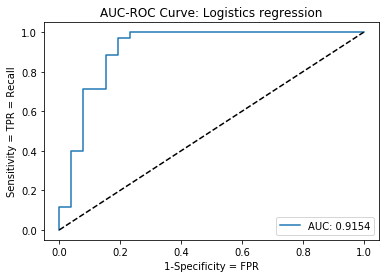

--------------------------------------------------------------




In [156]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
logistic = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
# print(cross_val_score(logistic, X_train_scale, y_train, cv=10))
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
scores=logistic.predict_proba(X_test)[:,1]

print('Reults for Logistics regression -')
metr_list = metric(y_test, y_pred, scores, 'Logistics regression')
common_metr_table.append(metr_list)
metr_table_field_names.append('Log regr')

### SVM

Reults for SVM classifier -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.918  |
|    Specificity    | 0.8077 |
|    Sensitivity    |  1.0   |
|     Precision     | 0.875  |
|        NPV        |  1.0   |
|        FPR        | 0.1923 |
|        RMC        | 0.082  |
|      F1 score     | 0.9333 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    21   |     5      |
|    No-Disease   |    0    |     35     |
+-----------------+---------+------------+


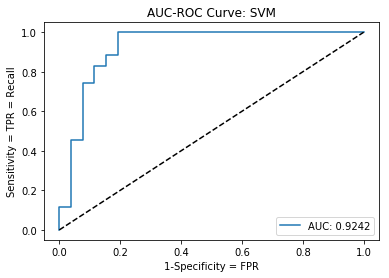

--------------------------------------------------------------




In [157]:
Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
gammas = [0.0001,0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
rbfsvm = GridSearchCV(svm.SVC(kernel='rbf',probability=True), param_grid, cv=5)
rbfsvm.fit(X_train_scale, y_train)
# print(grid_search.best_params_)
y_pred = rbfsvm.predict(X_test_scale)
scores=rbfsvm.predict_proba(X_test_scale)[:,1]
print('Reults for SVM classifier -')
metr_list = metric(y_test, y_pred, scores, 'SVM')
common_metr_table.append(metr_list)
metr_table_field_names.append('SVM')

### KNN

Reults for KNN -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8689 |
|    Specificity    | 0.8077 |
|    Sensitivity    | 0.9143 |
|     Precision     | 0.8649 |
|        NPV        | 0.875  |
|        FPR        | 0.1923 |
|        RMC        | 0.1311 |
|      F1 score     | 0.8889 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    21   |     5      |
|    No-Disease   |    3    |     32     |
+-----------------+---------+------------+


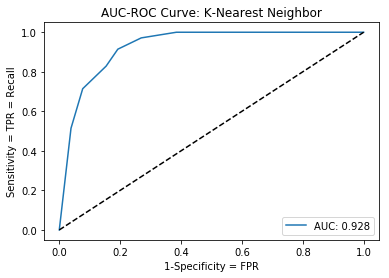

--------------------------------------------------------------




In [158]:
ks = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
Ps = [1,2,3]
param_grid = {'n_neighbors': ks, 'p' : Ps}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn.fit(X_train_scale, y_train)
# print(grid_search1.best_params_)
y_pred = knn.predict(X_test_scale)
scores=knn.predict_proba(X_test_scale)[:,1]
print('Reults for KNN -')
metr_list = metric(y_test, y_pred, scores, 'K-Nearest Neighbor')
common_metr_table.append(metr_list)
metr_table_field_names.append('KNN')

### NB

Reults for Naive Bayes classifier -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8689 |
|    Specificity    | 0.8846 |
|    Sensitivity    | 0.8571 |
|     Precision     | 0.9091 |
|        NPV        | 0.8214 |
|        FPR        | 0.1154 |
|        RMC        | 0.1311 |
|      F1 score     | 0.8824 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    23   |     3      |
|    No-Disease   |    5    |     30     |
+-----------------+---------+------------+


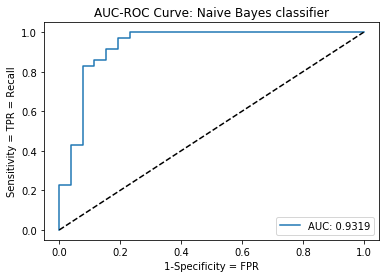

--------------------------------------------------------------




In [159]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
scores=nb.predict_proba(X_test)[:,1]
print('Reults for Naive Bayes classifier -')
metr_list = metric(y_test, y_pred, scores, 'Naive Bayes classifier')
common_metr_table.append(metr_list)
metr_table_field_names.append('NB')

### Decision Tree

Reults for Decision Tree classifier -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8197 |
|    Specificity    | 0.7692 |
|    Sensitivity    | 0.8571 |
|     Precision     | 0.8333 |
|        NPV        |  0.8   |
|        FPR        | 0.2308 |
|        RMC        | 0.1803 |
|      F1 score     | 0.8451 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    20   |     6      |
|    No-Disease   |    5    |     30     |
+-----------------+---------+------------+


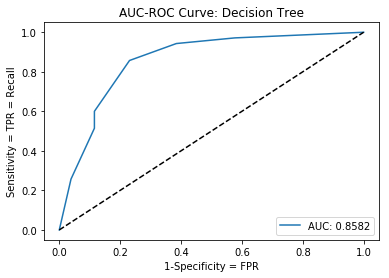

--------------------------------------------------------------




In [160]:
depth = np.linspace(1, 32, 32, endpoint=True)
min_split = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_lef = np.linspace(0.1, 0.5, 5, endpoint=True)
max_feat = list(range(1,X_train.shape[1]))
param_grid = {'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_lef,'max_features' : max_feat}
dtree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5,n_jobs=-1)
dtree.fit(X_train, y_train)
# print(grid_search2.best_params_)
y_pred = dtree.predict(X_test)
scores=dtree.predict_proba(X_test)[:,1]
print('Reults for Decision Tree classifier -')
metr_list = metric(y_test, y_pred, scores, 'Decision Tree')
common_metr_table.append(metr_list)
metr_table_field_names.append('Dec Tree')

### MLP

Reults for MultiLayer Perceptron classifier -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8525 |
|    Specificity    | 0.8077 |
|    Sensitivity    | 0.8857 |
|     Precision     | 0.8611 |
|        NPV        |  0.84  |
|        FPR        | 0.1923 |
|        RMC        | 0.1475 |
|      F1 score     | 0.8732 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    21   |     5      |
|    No-Disease   |    4    |     31     |
+-----------------+---------+------------+


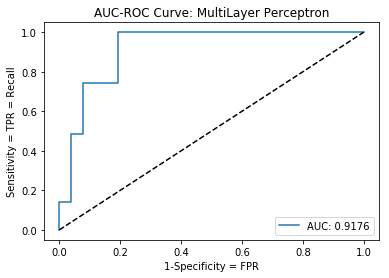

--------------------------------------------------------------




In [161]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,2), random_state=1)
# print(cross_val_score(mlp, X_train, y_train, cv=10))
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
scores=mlp.predict_proba(X_test)[:,1]
print('Reults for MultiLayer Perceptron classifier -')
metr_list = metric(y_test, y_pred,scores, 'MultiLayer Perceptron')
common_metr_table.append(metr_list)
metr_table_field_names.append('ANN')

### Random Forest (Bagging of 20 Decision Trees)

{'max_depth': 29.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'n_estimators': 22}
Reults for Random Forest classifier -
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.8852 |
|    Specificity    | 0.8462 |
|    Sensitivity    | 0.9143 |
|     Precision     | 0.8889 |
|        NPV        |  0.88  |
|        FPR        | 0.1538 |
|        RMC        | 0.1148 |
|      F1 score     | 0.9014 |
+-------------------+--------+

Confusion matrix : 
                   Predicted labels →
+-----------------+---------+------------+
| Actual labels ↓ | Disease | No-Disease |
+-----------------+---------+------------+
|     Disease     |    22   |     4      |
|    No-Disease   |    3    |     32     |
+-----------------+---------+------------+


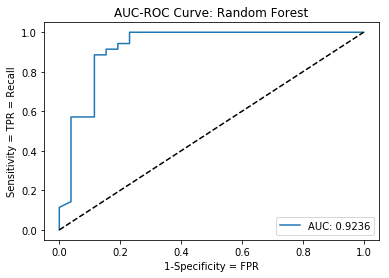

--------------------------------------------------------------




In [162]:
depth = np.linspace(1, 32, 32, endpoint=True)
min_split = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_lef = np.linspace(0.1, 0.5, 5, endpoint=True)
est = [20,21,22,23,24,25,26]
param_grid = {'n_estimators' : est,'max_depth': depth, 'min_samples_split' : min_split,'min_samples_leaf' : min_samples_lef}
rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=2,n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.best_params_)

y_pred = rf.predict(X_test)

scores=rf.predict_proba(X_test)[:,1]
print('Reults for Random Forest classifier -')
metr_list = metric(y_test, y_pred,scores, 'Random Forest')
common_metr_table.append(metr_list)
metr_table_field_names.append('Rand Forest')

Classwise ROC curves for all the classifier models combined -


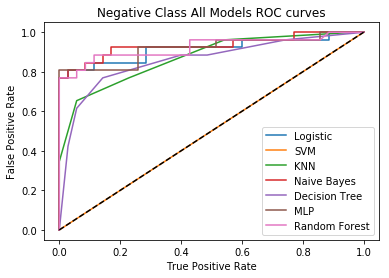

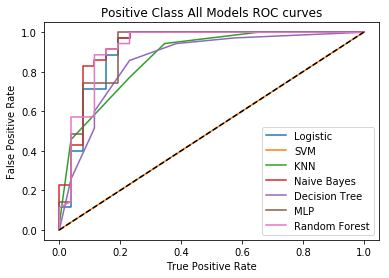

In [163]:
print("Classwise ROC curves for all the classifier models combined -")
rc([logistic,rbfsvm,knn,nb,dtree, mlp, rf], X_test, y_test, ['Logistic','SVM','KNN','Naive Bayes','Decision Tree', 'MLP', 'Random Forest'])

In [164]:
common_metr_table = np.array(common_metr_table).T

In [165]:
print('Tabulated Evaluation metrics for all models -')
x = PrettyTable()
print("                   Claassification models →")
x.field_names = ["Metrics ↓"] + metr_table_field_names
for i in range(len(common_metr_table)):
    x.add_row(common_metr_table[i])
print(x) 

Tabulated Evaluation metrics for all models -
                   Claassification models →
+-------------+----------+--------+--------+--------+----------+--------+-------------+
|  Metrics ↓  | Log regr |  SVM   |  KNN   |   NB   | Dec Tree |  ANN   | Rand Forest |
+-------------+----------+--------+--------+--------+----------+--------+-------------+
|   Accuracy  |  0.9016  | 0.918  | 0.8689 | 0.8689 |  0.8197  | 0.8525 |    0.8852   |
| Specificity |  0.8077  | 0.8077 | 0.8077 | 0.8846 |  0.7692  | 0.8077 |    0.8462   |
| Sensitivity |  0.9714  |  1.0   | 0.9143 | 0.8571 |  0.8571  | 0.8857 |    0.9143   |
|  Precision  |  0.8718  | 0.875  | 0.8649 | 0.9091 |  0.8333  | 0.8611 |    0.8889   |
|     NPV     |  0.9545  |  1.0   | 0.875  | 0.8214 |   0.8    |  0.84  |     0.88    |
|     FPR     |  0.1923  | 0.1923 | 0.1923 | 0.1154 |  0.2308  | 0.1923 |    0.1538   |
|     RMC     |  0.0984  | 0.082  | 0.1311 | 0.1311 |  0.1803  | 0.1475 |    0.1148   |
|   F1 score  |  0.9189  | 0.9